In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

#There are 70,000 images, and each image has 784 features. This is because each image
#is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
#(white) to 255 (black)


(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
print("First few elements of X:", X[:5])

First few elements of X: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


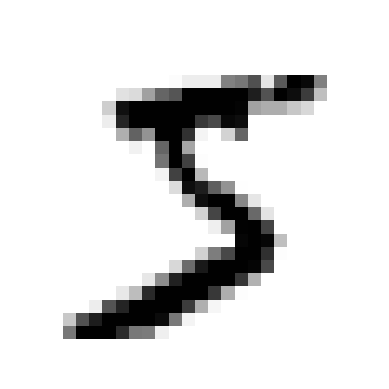

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y=y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#e MNIST dataset is actually already split into a training set (the first 60,000
#images) and a test set (the last 10,000 images)

   #### Training a Binary Classifier

In [11]:
y_train_5 = (y_train==5)
y_test_5 = (y_test == 5)

In [12]:
#Using Stochastic Gradient Classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

#The SGDClassifier relies on randomness during training (hence
#the name “stochastic”). If you want reproducible results, you
#should set the random_state parameter.

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# Perfomance Measures 

#### Measuring Accuracy Using Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
#Compare the 96% accuracy, to a dumb classifier that classifies every single image in the not "-5 " class

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#over 90% accuracy bc only about 10% of the images are 5s
#accuracy may not be the best method of perfomance measure for classifiers especially in skewed datasets 

array([0.91125, 0.90855, 0.90915])

#### Confusion Matrix

In [18]:
#the idea is to count the number of times instances of class Aare classified as class 
#look for a set of predictions and compare to actual targets

from sklearn.model_selection import cross_val_predict

y_train_pred =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

#ach row in a confusion matrix represents an actual class, while each column repre‐
#sents a predicted class..
#53892 were classified as non-5s(true negatives), 687 wrongly classified as 5s(false positives)
#second row considers images of 5s(positive class), 1891 were wrongly classified as non-5s (false negatives)
#while 3530 were classified as 5s (true positives)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### Precision and Recall 

In [23]:
from  sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #TP/(TP+FP) i.e 3530/(3530+687)

0.8370879772350012

In [24]:
#recall score
recall_score(y_train_5, y_train_pred) # == 3530/(3530+1891)

0.6511713705958311

In [25]:
#F1 score (the harmonic mean btn the two) - favors classifiers with similar precision and recall 

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
#DECISION THRESHOLD
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#raising the threshold reduces recall

#N/B >> Our image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
#threshold is increased to 8,000.

array([False])

In [32]:
#deciding which threshold to use
#get the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

ValueError: x and y must have same first dimension, but have shapes (60000,) and (60001,)

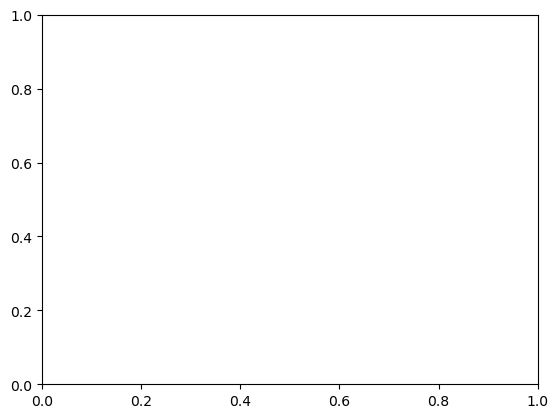

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions, "b--", label="Precision")
    plt.plot(thresholds, recalls, "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.grid(True)
    
    
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#### The ROC Curve
Receiver Operating characteristic curve - plots recall (TPR) against false positive rate(1-Specificity)

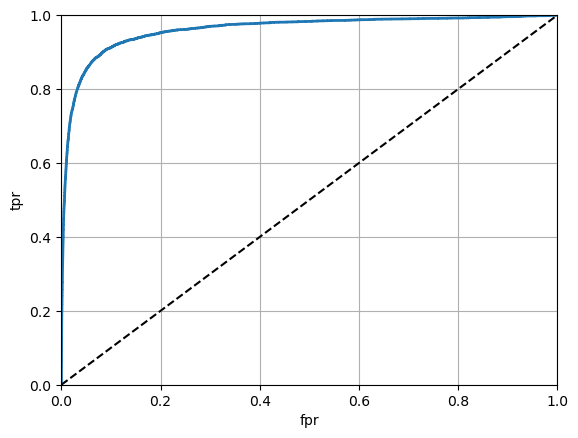

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()
     
#the higher the tpr(recall), the more the false positives
#dotted lins reps the ROC curve of a random classifier, a good classifier stays away from the line as much as possible
 

In [52]:
#calculate area under the curve(AUC) to compare classifiers
#perfect classifier should be AUC=1
#a purely random one should be AUC=0.5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### Random Forest Classifier
Train an RFC and compare its ROC curve, and ROC AUC scores to the SGDC one

In [54]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


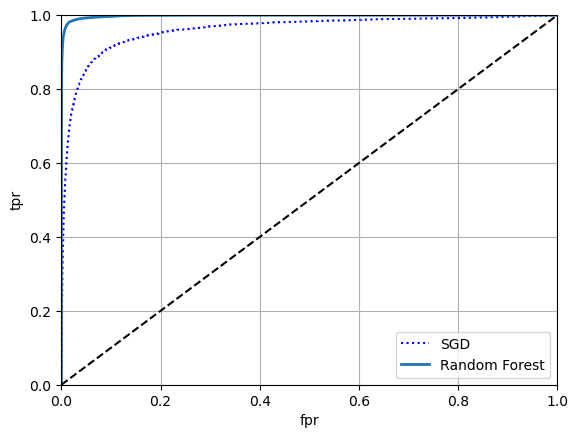

In [56]:
#plot the ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [64]:
#measure the precision and recall score (rem to convert the probabilities to binary first)

from  sklearn.metrics import precision_score, recall_score

y_pred_forest = (y_scores_forest > threshold).astype(int)
precision = precision_score(y_train_5, y_pred_forest)
recall = recall_score(y_train_5, y_pred_forest)

print("Precision:", precision)
print("Recall:", recall)

#random forest observed to have better precision

Precision: 0.15601795890174408
Recall: 1.0


#### Multiclass Classification 
    -also called multinomial classifiers,they can distinguish between more than two classes.